#Fresh Fruit Classification (Fresh and Rotten)


In [41]:
# modules
import  torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import kagglehub
import tensorflow as tf
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

In [42]:
# !rm -rf ~/.cache/torch/hub
# # !rm -rf ~/.cache/torch/checkpoints


In [43]:

read_file = ""

Model_Path = kagglehub.dataset_download("abdulrafeyyashir/fresh-vs-rotten-fruit-images")

print("Path to dataset files:", Model_Path)

Path to dataset files: /root/.cache/kagglehub/datasets/abdulrafeyyashir/fresh-vs-rotten-fruit-images/versions/4


['Fruit Freshness Dataset', 'README.dataset.txt']
Found 519 images


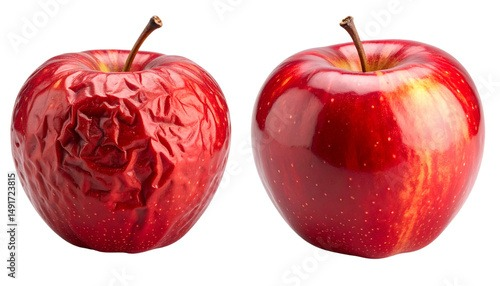

In [44]:
import os, glob, cv2
from google.colab.patches import cv2_imshow

dataset_root = Model_Path
# dataset_root = '/kaggle/input/fresh-vs-rotten-fruit-images'

# 1. see what is actually there
print(os.listdir(dataset_root))

# 2. common patterns
for ext in ('*.jpg','*.jpeg','*.png','*.zip'):
    files = glob.glob(os.path.join(dataset_root, '**', ext), recursive=True)
    if files:
        print('Found', len(files), 'images')
        # quick visual check
        img = cv2.imread(files[0])
        cv2_imshow(img)
        break
else:
    print('No image files found – maybe the dataset is shipped as a single archive?')

In [45]:
# restructure file to match up keras nomenclature
import pathlib
dataset_dir = pathlib.Path(dataset_root + "/" + "Fruit Freshness Dataset/Fruit Freshness Dataset")
dataset_dir

image_paths = list(dataset_dir.glob("*/*/*"))
image_paths = [str(path) for path in image_paths]

print(image_paths[:5])

# extracting labels from path
def parse_path(path):
  parts = tf.strings.split(path, "/")

  fruit = parts[-3]
  freshness = parts[-2]

  return fruit, freshness

# string to integer
fruit_lookup = tf.keras.layers.StringLookup()
freshness_lookup = tf.keras.layers.StringLookup()

fruit_labels = []
freshness_labels = []

for path in image_paths:
  f, fr = parse_path(path)
  fruit_labels.append(f)
  freshness_labels.append(fr)

fruit_lookup.adapt(fruit_labels)
freshness_lookup.adapt(freshness_labels)

print("Fruit classes:", fruit_lookup.get_vocabulary())
print("Freshness classes:", freshness_lookup.get_vocabulary())



['/root/.cache/kagglehub/datasets/abdulrafeyyashir/fresh-vs-rotten-fruit-images/versions/4/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Rotten/apple_rotten_001.jpg (46).jpg', '/root/.cache/kagglehub/datasets/abdulrafeyyashir/fresh-vs-rotten-fruit-images/versions/4/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Rotten/apple_rotten_001.jpg (34).jpg', '/root/.cache/kagglehub/datasets/abdulrafeyyashir/fresh-vs-rotten-fruit-images/versions/4/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Rotten/apple_rotten_001.jpg (4).jpg', '/root/.cache/kagglehub/datasets/abdulrafeyyashir/fresh-vs-rotten-fruit-images/versions/4/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Rotten/apple_rotten_001.jpg (32).jpg', '/root/.cache/kagglehub/datasets/abdulrafeyyashir/fresh-vs-rotten-fruit-images/versions/4/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Rotten/apple_rotten_001.jpg (7).jpg']
Fruit classes: ['[UNK]', np.str_('Strawberry'), np.str_('Apple'), np.str_('Banana')]
F

In [46]:
IMG_SIZE = (224, 224)

def load_image(path):
    # Load image
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0

    # Extract labels
    fruit, freshness = parse_path(path)

    fruit_id = fruit_lookup(fruit)
    freshness_id = freshness_lookup(freshness)

    return img, (fruit_id, freshness_id)


In [47]:
# BATCH_SIZE = 32

# ds = tf.data.Dataset.from_tensor_slices(image_paths)
# ds = ds.shuffle(len(image_paths))
# ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
# ds = ds.batch(BATCH_SIZE)
# ds = ds.prefetch(tf.data.AUTOTUNE)


from PIL import Image
from torch.utils.data import Dataset

class FruitFreshnessDataset(Dataset):
    def __init__(self, image_paths, fruit_lookup, freshness_lookup, transform=None):
        self.image_paths = image_paths
        self.fruit_lookup = fruit_lookup
        self.freshness_lookup = freshness_lookup
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]

        # Load image safely (PIL supports jpg/png/webp/jfif)
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Extract labels
        parts = path.split(os.sep)
        fruit = parts[-3]
        freshness = parts[-2]

        fruit_id = self.fruit_lookup[fruit]
        freshness_id = self.freshness_lookup[freshness]

        return image, (fruit_id, freshness_id)


In [48]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [49]:
import os
fruits = sorted(set([p.split(os.sep)[-3] for p in image_paths]))
freshness = sorted(set([p.split(os.sep)[-2] for p in image_paths]))

fruit_to_idx = {f: i for i, f in enumerate(fruits)}
freshness_to_idx = {f: i for i, f in enumerate(freshness)}

num_fruits = len(fruit_to_idx)
num_freshness = len(freshness_to_idx)


In [50]:
from sklearn.model_selection import train_test_split

train_paths, val_paths = train_test_split(
    image_paths, test_size=0.2, random_state=42, shuffle=True
)


In [51]:
train_ds = FruitFreshnessDataset(
    train_paths, fruit_to_idx, freshness_to_idx, transform
)

val_ds = FruitFreshnessDataset(
    val_paths, fruit_to_idx, freshness_to_idx, transform
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)


In [52]:
# def build_dataset(paths, batch_size, training=True):
#     ds = tf.data.Dataset.from_tensor_slices(paths)

#     if training:
#         ds = ds.shuffle(len(paths))

#     ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
#     ds = ds.batch(batch_size)
#     ds = ds.prefetch(tf.data.AUTOTUNE)

#     return ds


In [53]:
# split_ratio = 0.8
# split_index = int(len(image_paths) * split_ratio)

# train_paths = image_paths[:split_index]
# val_paths = image_paths[split_index:]

# BATCH_SIZE = 32

# train_ds = build_dataset(train_paths, BATCH_SIZE, training=True)
# test_ds   = build_dataset(val_paths, BATCH_SIZE, training=False)


In [54]:
# from sklearn.utils.validation import validate_data
# # # Let's split the data into train and test

# data_dir = dataset_root + "/" + "Fruit Freshness Dataset/Fruit Freshness Dataset"
# batch_size = 32
# img_size = (254,254)


# train_ds = tf.keras.utils.image_dataset_from_directory(
#      data_dir,
#     validation_split=0.2,   # 80 % train, 20 % val
#     subset="training",
#     seed=123,
#     image_size=img_size,
#     batch_size=batch_size)


# test_ds = tf.keras.utils.image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,
#     subset="validation",
#     seed=123,
#     image_size = img_size,
#     batch_size = batch_size,
# )

In [55]:
# check few metrics

# image_classes = train_ds.class_names
# print(type(train_ds))
# # image, label = train_ds[1]



In [56]:
# import os, pathlib
# cache_dir = pathlib.Path('/root/.cache/torch/hub/checkpoints')
# bad_file  = cache_dir / 'resnet50-0676ba61.pth'
# if bad_file.exists():
#     bad_file.unlink()          # remove corrupted file

In [57]:
# model using ResNet50

# base_model = tf.keras.applications.ResNet50(
#         input_shape=(254, 254, 3),
#     include_top=False,
#     weights='imagenet'
# )

# base_model.trainable = False

# model = tf.keras.Sequential(
#     [tf.keras.layers.Rescaling(1./255),
#      base_model,
#      tf.keras.layers.GlobalAveragePooling2D(),
#      tf.keras.layers.Dropout(0.3),
#      tf.keras.layers.Dense(3, activation="softmax")
#      ]
# )

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

class FreshvsRotten(nn.Module):
  def __init__(self, num_classes, output_features):
    super().__init__()

    self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

    for param in self.backbone.parameters():
      param.requires_grad = False

    for param in self.backbone.layer4.parameters():
      param.requires_grad = True

    num_features = self.backbone.fc.in_features
    self.backbone.fc = nn.Identity()


        # Fruit classification head
    self.fruit_classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(num_features, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(256, num_classes)
    )

    # Freshness classification head
    self.freshness_classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(num_features, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(256, output_features)
    )

  def forward(self, x):
            # Extract features
    features = self.backbone(x)

    # Pass through both classifiers
    fruit_output = self.fruit_classifier(features)
    freshness_output = self.freshness_classifier(features)

    return fruit_output, freshness_output


model = FreshvsRotten(num_classes=3, output_features=2)
model





FreshvsRotten(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [58]:
loss_fn_fruit = nn.CrossEntropyLoss()
loss_fn_freshness = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [59]:
# for batch in train_ds.take(1):
#     X, y = batch
#     print("X shape:", X.shape)
#     print("y shape:", y.shape)
#     print("y dtype:", y.dtype)


In [60]:
# Train and Test Loop

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(device)

epochs = 10
training_loss_array = []
testing_loss_array = []

for epoch in tqdm(range(epochs)):

  model.train()
  training_loss = 0
  num_of_samples = 0
  running_loss = 0

  epoch_training_loss = 0

  for X, (y_fruit_pred, y_freshness_pred) in train_loader:
    X, y_fruit_pred , y_freshness_pred = X.to(device), y_fruit_pred.to(device), y_freshness_pred.to(device)


    # forward pass
    fruit_pred, freshness_pred = model(X)

    fruit_loss = loss_fn_fruit(fruit_pred, y_fruit_pred)
    freshness_loss = loss_fn_freshness(freshness_pred, y_freshness_pred)

    loss = fruit_loss + freshness_loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
    batch_size = X.size(0)
    running_loss = loss.item() * batch_size
    num_of_samples += batch_size
    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Loss: | "
        f"Val Loss: {running_loss:.4f}"
    )

  epoch_training_loss += running_loss / num_of_samples
  training_loss_array.append(epoch_training_loss)



  model.eval()

  testing_loss = 0
  num_of_test_samples = 0
  test_running_loss = 0
  epoch_test_loss = 0
  with torch.inference_mode():

    for  X, (y_fruit_pred, y_freshness_pred) in (val_loader):
      X, y_fruit_pred , y_freshness_pred = X.to(device), y_fruit_pred.to(device), y_freshness_pred.to(device)
      test_fruit_pred, test_freshness_pred = model(X)
      freshness_loss = loss_fn_freshness(test_freshness_pred, y_freshness_pred)
      fruit_loss = loss_fn_fruit(test_fruit_pred, y_fruit_pred)
      test_loss = fruit_loss + freshness_loss

      batch_size = X.size(0)
      num_of_samples += batch_size
      test_running_loss += test_loss.item() * batch_size

  # epoch_test_loss = test_running_loss / num_of_test_samples
  if num_of_test_samples > 0:
    epoch_test_loss = test_running_loss / num_of_test_samples
  else:
    epoch_test_loss = float("nan")

  testing_loss_array.append(epoch_test_loss)
  print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Loss: {test_running_loss:.4f} | "
        f"Val Loss: {epoch_test_loss:.4f}"
    )


print(f"Traing loss array : {training_loss_array}")
print(f"Testing loss array : {testing_loss_array}")






cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10] | Train Loss: | Val Loss: 56.5589
Epoch [1/10] | Train Loss: | Val Loss: 61.2914
Epoch [1/10] | Train Loss: | Val Loss: 27.3007
Epoch [1/10] | Train Loss: | Val Loss: 16.8968
Epoch [1/10] | Train Loss: | Val Loss: 10.5205
Epoch [1/10] | Train Loss: | Val Loss: 4.9423
Epoch [1/10] | Train Loss: | Val Loss: 6.9167
Epoch [1/10] | Train Loss: | Val Loss: 16.0089
Epoch [1/10] | Train Loss: | Val Loss: 21.2123
Epoch [1/10] | Train Loss: | Val Loss: 7.2488
Epoch [1/10] | Train Loss: | Val Loss: 2.6622
Epoch [1/10] | Train Loss: | Val Loss: 4.8228
Epoch [1/10] | Train Loss: | Val Loss: 7.8872
Epoch [1/10] | Train Loss: | Val Loss: 8.8119
Epoch [1/10] | Train Loss: | Val Loss: 17.9174
Epoch [1/10] | Train Loss: 99.5967 | Val Loss: nan
Epoch [2/10] | Train Loss: | Val Loss: 2.4948
Epoch [2/10] | Train Loss: | Val Loss: 3.2006
Epoch [2/10] | Train Loss: | Val Loss: 3.7345
Epoch [2/10] | Train Loss: | Val Loss: 7.0939
Epoch [2/10] | Train Loss: | Val Loss: 34.4932
Epoch [2/10] | Train

Text(0, 0.5, 'loss')

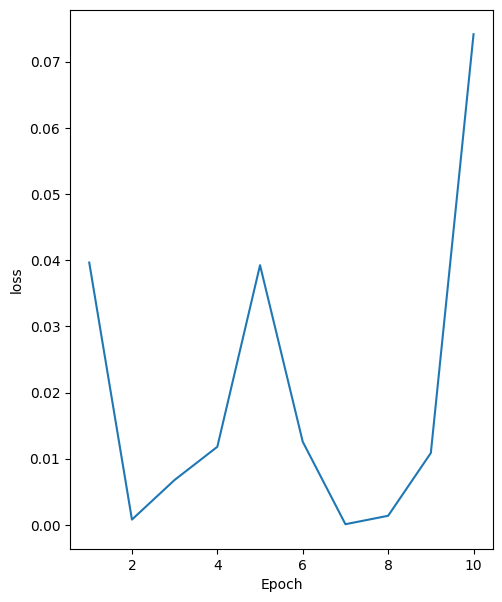

In [61]:
# Plotting the curve

epoch_range = range(1, epochs +1)

plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.plot(epoch_range, training_loss_array)
plt.xlabel("Epoch")
plt.ylabel("loss")